In [146]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# build the vocabulary of caracters and mappings to/from intergers  
words = open('names.txt','r').read().splitlines()

chars = sorted(set("".join(words)))
stoi  = {s:i for i,s in enumerate(chars, start=1)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [74]:
# build the dataset 
block_size = 3  # context length, we take 'e','m','m' to predict 'a'
X,Y = [],[]

for w in words[:5]: 
    print(w)
    context = [0] * block_size # pre-pend empty char
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [35]:
C = torch.randn((27,2))  # one char to 2 features

In [36]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [37]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [38]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [39]:
emb.view(32,6).shape

torch.Size([32, 6])

In [40]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [41]:
h

tensor([[-0.9999,  1.0000,  0.9884,  ...,  0.4261,  0.9780, -0.9979],
        [-0.9999,  1.0000,  0.8450,  ...,  0.7682,  0.9988, -0.9980],
        [-0.9998,  1.0000,  0.0192,  ...,  0.4488,  0.9975, -0.9983],
        ...,
        [-0.1232, -0.6877, -0.6171,  ..., -0.9956,  0.0086,  0.2835],
        [ 0.4380, -0.8518,  0.5147,  ..., -0.0351,  0.9868, -0.1450],
        [ 0.7569, -0.8352, -0.9983,  ...,  0.9683,  0.9999,  0.9989]])

In [42]:
h.shape

torch.Size([32, 100])

In [43]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [49]:
loss = -prob[torch.arange(32), Y].log().mean()

In [151]:
# now made respectable 

# build the whole dataset 
block_size = 3  # context length, we take 'e','m','m' to predict 'a'
X,Y = [],[]

for w in words: 
    context = [0] * block_size # pre-pend empty char
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)


X.shape, Y.shape  # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [152]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)    # one char to 2 features, feature layer
W1 = torch.randn((6,100), generator=g)  # hidden layer
b1 = torch.randn(100, generator=g)    
W2 = torch.randn((100, 27), generator=g)# output layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
                 

In [153]:
sum(p.nelement() for p in parameters)  # total number of parameters

for p in parameters:
    p.requires_grad = True

In [154]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre

In [166]:
lri = []
lossi = []

for i in range(1000):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])   # same as -prob[torch.arange(32), Y].log().mean()
    print(loss.item())
    # backward 
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    lr = torch.tensor(0.1)
    for p in parameters:
        p.data += -lr * p.grad
        
    lri.append(lr.item())
    lossi.append(loss.item())

9.597136497497559
7.142675876617432
6.832259178161621
5.6760077476501465
5.360262870788574
5.875588417053223
5.2005486488342285
4.859124183654785
4.4813456535339355
3.7911734580993652
3.755026340484619
3.8266823291778564
5.9967875480651855
3.5642831325531006
5.058723449707031
4.592010021209717
4.819126129150391
4.256728649139404
4.200345039367676
4.240828514099121
5.150032997131348
4.826585292816162
4.0075364112854
4.436812877655029
3.3953661918640137
4.232844352722168
3.7584569454193115
4.459029674530029
4.362961292266846
3.2371020317077637
3.391993284225464
4.01809549331665
4.3578572273254395
3.815572738647461
3.7850146293640137
2.929777145385742
3.4474213123321533
3.1727287769317627
4.338604927062988
3.041611433029175
3.1665613651275635
3.207062005996704
3.2419137954711914
3.441899299621582
3.4380815029144287
3.6589105129241943
3.957235813140869
3.3321311473846436
3.1605498790740967
3.324756145477295
3.7649576663970947
3.721874952316284
3.863234519958496
3.7445197105407715
3.0960993

2.850964069366455
3.051682710647583
2.4269161224365234
2.91072678565979
2.5492162704467773
2.8579862117767334
2.7552337646484375
2.6836097240448
2.8166568279266357
2.5906286239624023
2.7890303134918213
3.0159058570861816
2.3851256370544434
2.4795610904693604
2.8860232830047607
2.676934242248535
2.3421826362609863
2.741931200027466
2.660228967666626
2.8505823612213135
2.3726325035095215
2.535268783569336
2.3804736137390137
2.968569755554199
2.3092663288116455
2.332775354385376
2.5314083099365234
2.6477932929992676
2.6654632091522217
2.6562299728393555
2.8952183723449707
2.6110494136810303
2.8023681640625
2.850015640258789
2.351132392883301
2.5309836864471436
2.878387212753296
2.7323923110961914
2.22379469871521
2.430647850036621
2.5510494709014893
2.421910285949707
3.0240681171417236
2.7542316913604736
2.447814702987671
2.656017303466797
2.593015670776367
3.121459484100342
2.7315733432769775
2.877533435821533
3.551259994506836
3.0299787521362305
2.671365976333618
2.862180233001709
2.435

In [169]:
# evaluate on the entire set
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6100, grad_fn=<NllLossBackward0>)

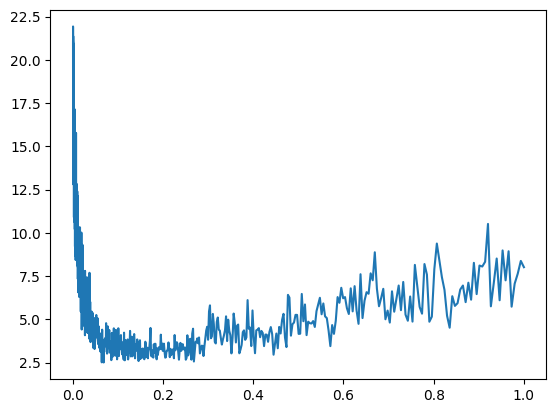

In [156]:
plt.plot(lri, lossi)

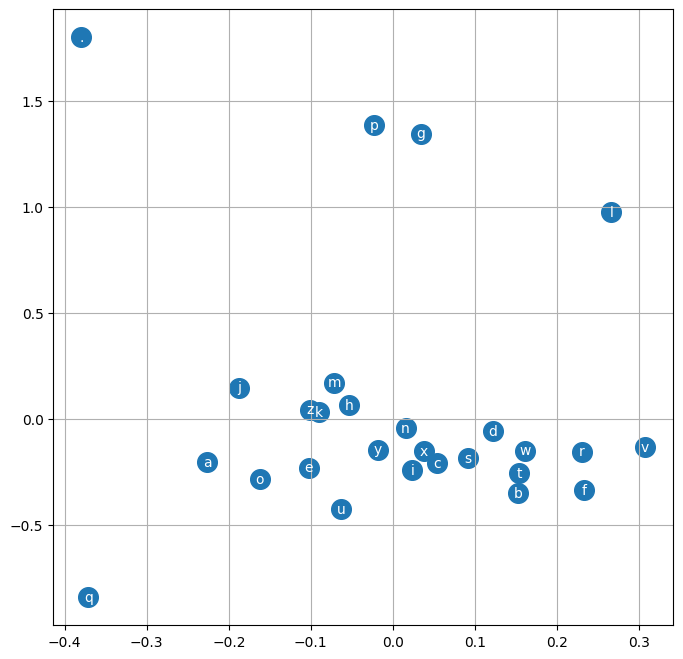

In [168]:
# visualize the embedding
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center",va="center",color="white")
plt.grid('minor')